# AVISO
### Este notebook está hecho para correr en un notebook de VertexAI en una instancia de Google Cloud
Su inclusión en este repositorio es pura y exclusivamente demostrativa para demostrar nuestro proceso de limpieza y subida de datos para el catálogo.

## Dependencias

In [ ]:
!pip install pandas
!pip install pillow
!pip install openpyxl
!pip install requests
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install scipy
!pip install google-cloud-storage
!pip install google-cloud-vision
!pip install google-cloud-aiplatform
!pip install tqdm
!pip install aiohttp

In [ ]:
# Autenticar el colab (NO funciona en vscode, buscar autenticación vía gcloud o service account: https://cloud.google.com/docs/authentication)
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

In [3]:
# Google Cloud
import vertexai
from vertexai.preview.generative_models import GenerativeModel
from vertexai.preview.language_models import TextGenerationModel

# Google Credentials
from google.auth.transport.requests import Request
from google.auth import default

In [4]:
PROJECT_ID = "identifeye" #@param
REGION = "us-central1" #@param
vertexai.init(project=PROJECT_ID, location=REGION)

## I. Extraer archivos


### Extraer y almacenar SKUs con imágenes en link
Las imágenes se extraen el pandas df (previamente el Excel) y se convierten en un json. </br>
max_iters en ambas celdas define el máximo de líneas del Excel que se quieren leer. </br>
Se utiliza concurrencia para acelerar la ejecución de la descarga de imágenes.

In [5]:
# Lectura del archivo
import pandas as pd
import json

# Ruta al archivo xlsx
file_path = 'imgs.xlsx'

# Leer el archivo xlsx
try:
  df = pd.read_excel(file_path)
  print("Archivo xlsx leído correctamente.")
except Exception as e:
  print(f"Error al leer el archivo xlsx: {e}")


Archivo xlsx leído correctamente.


In [ ]:
# Generación de un diccionario, a partir de la extracción de información
def row_to_json(row):
    key = row['SKU']
    value_name = row['Name']
    value_attrs = row['Atributos']
    attrs_list = str(value_attrs).split("|")

    list_values = [img for img in row[3:] if img is not None and pd.notna(img)]

    return {
        key: {
            'name': value_name,
            'atributos': attrs_list,
            'imgs': list_values
        }
    }

# Aplicar la función a cada fila del DataFrame
max_iters = 1033

json_data = {
    'result': {
        row['SKU']: row_to_json(row)[row['SKU']]
        for index, row in df.iterrows() if index <= max_iters
        }
}

# Convertir la lista de diccionarios a JSON
json_output = json.dumps(json_data, indent=4, ensure_ascii=False)

json_data

In [ ]:
import concurrent.futures
import os
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from vertexai.vision_models import Image, MultiModalEmbeddingModel
from PIL import Image
import requests
from tqdm import tqdm

# Directorio de imágenes
images_dir = 'imagenes_descargadas'
os.makedirs(images_dir, exist_ok=True)

def descargar_imagen(url, sku, index):
    """Descarga una imagen y la guarda con un nombre basado en el SKU y el índice."""
    img_path = os.path.join(images_dir, f"{sku}_{index}.jpg")
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(img_path, 'wb') as file:
                for chunk in response.iter_content(1024):
                    file.write(chunk)
        return img_path
    except Exception as e:
        print(f"Error descargando {url}: {e}")
        return None

def descargar_imagenes_concurrente(json_data):
    imagenes_dict = {}
    max_iters = 1033  # Limitar a 1033 SKUs procesados
    idx = 0

    with concurrent.futures.ThreadPoolExecutor(max_workers=30) as executor:
        futures = {
            executor.submit(descargar_imagen, url, sku, i): (sku, i)
            for sku, details in json_data['result'].items()
            for i, url in enumerate(details.get('imgs', [])[:3])
            if pd.notna(url)
        }
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            img_path = future.result()
            sku, _ = futures[future]
            if img_path:
                imagenes_dict.setdefault(sku, []).append(img_path)

    # Intentar descargar hasta 30 imágenes por SKU con 30 hilos simultáneos
    with concurrent.futures.ThreadPoolExecutor(max_workers=30) as executor:
        futures = []
        for sku, details in json_data['result'].items():
            if idx >= max_iters:  # Verificar el límite de SKUs
                break
            list_values = details.get('imgs', [])
            for i in range(3, min(len(list_values), 30)):  # Descargar hasta 30 imágenes
                url = list_values[i]
                if pd.notna(url):
                    futures.append(executor.submit(descargar_imagen, url, sku, i))
            idx += 1  # Incrementar el contador de SKUs procesados

        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            img_path = future.result()
            if img_path:
                sku = os.path.basename(img_path).split('_')[0]  # Extraer SKU del nombre de archivo
                imagenes_dict.setdefault(sku, []).append(img_path)

    return imagenes_dict


imagenes_dict = descargar_imagenes_concurrente(json_data)
imagenes_dict


## II Embeddings

Sacamos 128 embeddings de cada imagen que descargamos del catálogo, este proceso es mucho mas lento debido a las cuotas de VertexAI para procesos por minuto.

In [14]:
import vertexai
import os
from vertexai.vision_models import Image, MultiModalEmbeddingModel
from concurrent.futures import ThreadPoolExecutor, as_completed

# Load the pre-trained model
model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding")

folder = "imagenes_descargadas"
list_of_images = os.listdir(folder)

# Function to process a single image and extract its embedding
def process_image(image_name):
    try:
        image_path = os.path.join(folder, image_name)
        image_part = Image.load_from_file(image_path)
        embedding = model.get_embeddings(image=image_part, dimension=128).image_embedding
        return image_name, image_part, embedding
    except Exception as e:
        print(f"Error processing {image_name}: {e}")
        return image_name, None, None

# Use ThreadPoolExecutor for concurrent processing
images = {}
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = [executor.submit(process_image, image) for image in list_of_images]

    count = 0
    # Collect results as they complete
    for future in as_completed(futures):
        count = count + 1
        print("Image ", count)
        image_name, image_part, embedding = future.result()
        if embedding is not None:
            images[image_name] = {
                "image_part": image_part,
                "embedding": embedding
            }

# Display the result (optional)
print(f"Processed {len(images)} images with embeddings.")



# #image = Image.load_from_file()

# embeddings = model.get_embeddings(
#     image=image,
#     dimension=1408,
# )
# print(f"Image Embedding: {embeddings.image_embedding}")
# print(f"Text Embedding: {embeddings.text_embedding}")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Image  2016
Image  2017
Image  2018
Image  2019
Image  2020
Image  2021
Image  2022
Image  2023
Image  2024
Image  2025
Image  2026
Image  2027
Image  2028
Image  2029
Image  2030
Image  2031
Image  2032
Image  2033
Image  2034
Image  2035
Image  2036
Image  2037
Image  2038
Image  2039
Image  2040
Image  2041
Image  2042
Image  2043
Image  2044
Image  2045
Image  2046
Image  2047
Image  2048
Image  2049
Image  2050
Image  2051
Image  2052
Image  2053
Image  2054
Image  2055
Image  2056
Image  2057
Image  2058
Image  2059
Image  2060
Image  2061
Image  2062
Image  2063
Image  2064
Image  2065
Image  2066
Image  2067
Image  2068
Image  2069
Image  2070
Image  2071
Image  2072
Image  2073
Image  2074
Image  2075
Image  2076
Image  2077
Image  2078
Image  2079
Image  2080
Image  2081
Image  2082
Image  2083
Image  2084
Image  2085
Image  2086
Image  2087
Image  2088
Image  2089
Image  2090
Image  2091
Image  2092
Image  20

# III Plottear los embeddings
Los embeddings se plotean para poder ver bidimensionalmente su cercanía, calcular su mejor Epsilon para el mejor descarte de duplicados y se grafican los clusters a los que pertenecen. </br>
Con un gran número de embeddings los gráficos empiezan a verte como un hoyo negro debido a la cantidad de puntos.

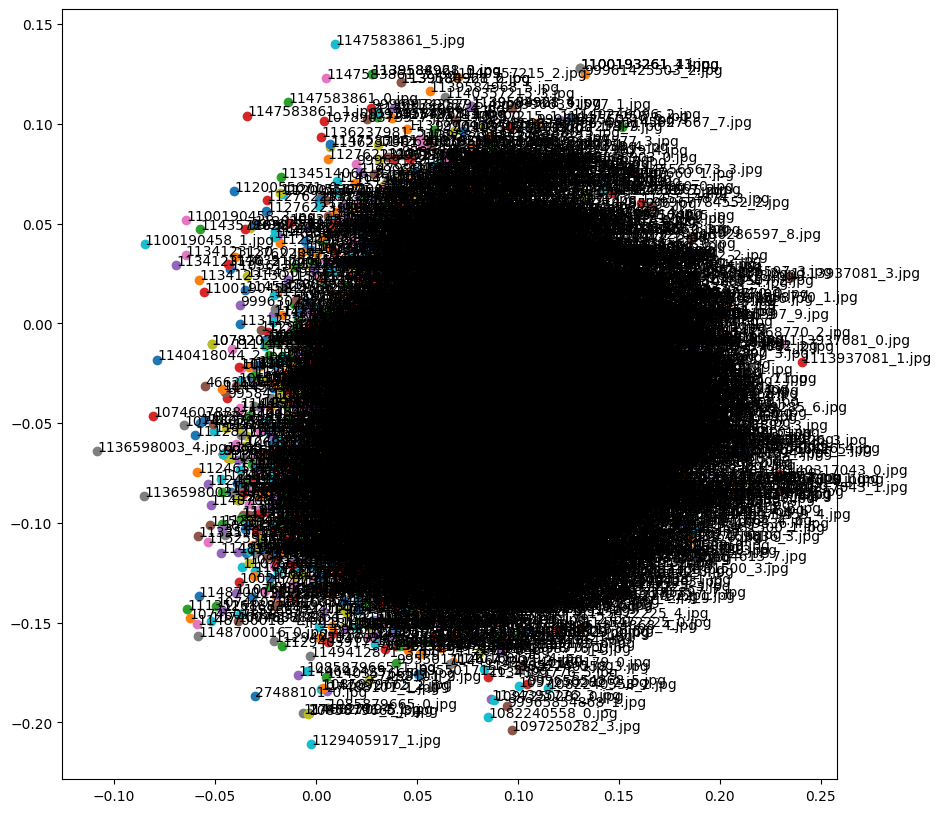

In [15]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10, 10))

for image in images:
    embedding = images[image]["embedding"]
    x = embedding[0]
    y = embedding[1]
    plt.scatter(x, y, label=image)
    # annotating image names
    plt.text(x, y, image)
plt.show()


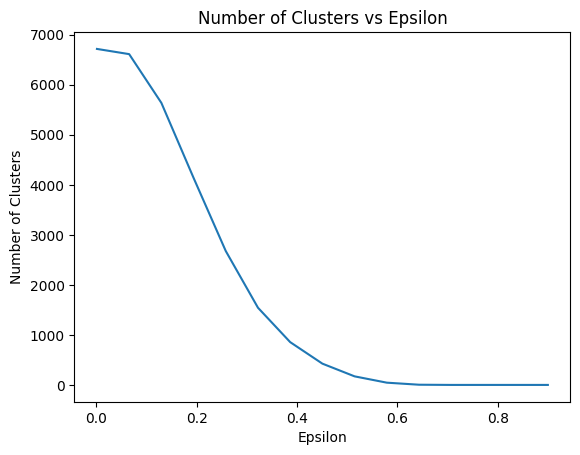

In [16]:
# Applying dbscan to find similar images
import numpy as np
from sklearn.cluster import DBSCAN
#from sklearn.preprocessing import StandardScaler

Epsilon = np.linspace(0.001, 0.9, 15)
METRIC = 'euclidean' # 'cosine'

num_clusters = {}
for epsilon in Epsilon:
    dbscan = DBSCAN(eps=epsilon, metric=METRIC, min_samples=1)
    embeddings = [images[image]["embedding"] for image in images]
    classes = dbscan.fit_predict(embeddings)
    num_classes = len(set(classes))
    num_clusters[epsilon] = num_classes

# plot the number of clusters vs epsilon
plt.plot(Epsilon, list(num_clusters.values()))
plt.xlabel('Epsilon')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs Epsilon')
plt.show()


Using  2839  clusters


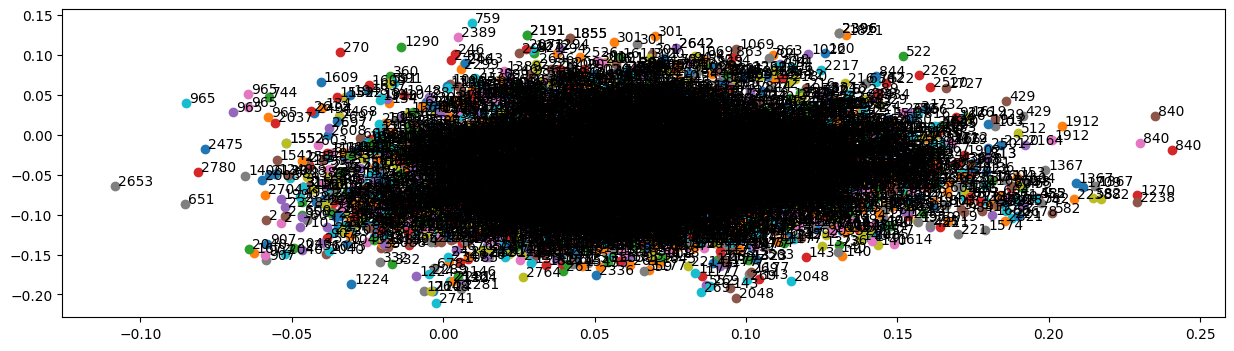

In [17]:
# digamos epsilon =0.3

epsilon = 0.25
dbscan = DBSCAN(eps=epsilon, metric=METRIC, min_samples=1)
embeddings = [images[image]["embedding"] for image in images]
classes = dbscan.fit_predict(embeddings)
print("Using ",len(set(classes)), " clusters")

# plot the clusters
fig = plt.figure(figsize=(15, 4))
for i, image in enumerate(images):
    embedding = images[image]["embedding"]
    x = embedding[0]
    y = embedding[1]
    plt.scatter(x, y, label=f"{classes[i]}")
    # annotating image names
    plt.text(x+0.001, y+0.001, f"{classes[i]}")

## IV. Borrado de fotografías repetidas
En este paso vamos iterando por cada cluster y guardamos los duplicados (puntos con distancias prácticamente nulas) para posteriormente borrarlos tanto de la carpeta de imágenes como del json de images mediante el SDK.

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, as_completed

# Folder containing the images
folder = "imagenes_descargadas"

# List all files in the folder before deletion
initial_file_count = len(os.listdir(folder))
print(f"Initial number of files: {initial_file_count}")

# Identify clusters with duplicate images
clusters_with_repeated_images = [
    int(cluster_num) for cluster_num in set(classes) if list(classes).count(cluster_num) > 1
]

# Track images to delete (keep only one per cluster)
files_to_delete = []

for cluster in clusters_with_repeated_images:
    print(f"Cluster {cluster} (Duplicates Found):")
    cluster_images = [
        image_name for i, image_name in enumerate(images) if classes[i] == cluster
    ]

    # Display all images in the cluster (optional)
    for image_name in cluster_images:
        print(f"\t{image_name}")

    # Keep only the first image, mark the rest for deletion
    files_to_delete.extend(cluster_images[1:])

# Function to delete a file and update the dictionary
def delete_file_and_update_dict(file_name):
    """Delete the file and remove its entry from the images dictionary."""
    try:
        file_path = os.path.join(folder, file_name)
        if os.path.exists(file_path):
            os.remove(file_path)  # Delete the file
            print(f"Deleted: {file_name}")

            # Remove from images dictionary if it exists
            if file_name in images:
                del images[file_name]
                print(f"Removed {file_name} from the images dictionary.")
            return True  # Return True if successful
        else:
            print(f"File not found: {file_name}")
            return False
    except Exception as e:
        print(f"Error deleting {file_name}: {e}")
        return False

# Use ThreadPoolExecutor to delete files and update the dictionary concurrently
with ThreadPoolExecutor(max_workers=30) as executor:
    futures = {executor.submit(delete_file_and_update_dict, file_name): file_name for file_name in files_to_delete}

    # Collect results as they complete
    for future in as_completed(futures):
        result = future.result()
        file_name = futures[future]
        if result:
            print(f"Successfully deleted and removed: {file_name}")
        else:
            print(f"Failed to delete: {file_name}")

# Count the remaining files in the folder
final_file_count = len(os.listdir(folder))
print(f"Final number of files: {final_file_count}")

# Display the difference in file count
print(f"Number of files deleted: {initial_file_count - final_file_count}")

## V. Conexión con base de datos en Firebase
Nos conectamos a Firebase mediante nuestra secret key y subimos todos los embeddings para posteriormente procesar productos parecidos rápidamente.

In [ ]:
import firebase_admin
from firebase_admin import credentials, firestore
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

# Initialize Firebase app
cred = credentials.Certificate('./firebase/serviceAccountKey.json')
#firebase_admin.initialize_app(cred)

# Initialize Firestore
db = firestore.client()

# Function to upload a single embedding to Firestore
def upload_embedding(image_name, embedding):
    # Convert embedding to list if it's a NumPy array
    if isinstance(embedding, np.ndarray):
        embedding = embedding.tolist()

    # Upload to Firestore
    try:
        db.collection('embeddings').document(image_name).set({
            'embedding': embedding
        })
        print(f"Uploaded embedding for {image_name}")
        return True
    except Exception as e:
        print(f"Error uploading {image_name}: {e}")
        return False

# Use ThreadPoolExecutor to upload embeddings concurrently
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = [
        executor.submit(upload_embedding, image_name, images[image_name]["embedding"])
        for image_name in images
    ]

    # Collect results as they complete
    for future in as_completed(futures):
        success = future.result()
        if success:
            print("Successfully uploaded an embedding.")
        else:
            print("Failed to upload an embedding.")

print("All embeddings have been processed.")


## VI. Detección de imagenes similares
El paso principal del programa consiste de sacarle los embeddings a la foto de entrada e ir comparando su distancia con cada uno de los embeddings que tenemos. Este paso usa concurrencia para aumentar la velocidad significativamente. Finalmente tomamos el SDK de la relación con menor distancia y regresamos todas las imágenes que empiecen con ese mismo SDK.

In [24]:
from vertexai.vision_models import Image, MultiModalEmbeddingModel

# Cargar la imagen de entrada
input_image_path = "./prueba.png"
input_image = Image.load_from_file(input_image_path)

# Inicializa el modelo (si no lo has hecho)
model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding")

# Calcular el embedding de la imagen de entrada
input_embedding = model.get_embeddings(image=input_image, dimension=128).image_embedding


In [26]:
import firebase_admin
from firebase_admin import credentials, firestore
from concurrent.futures import ThreadPoolExecutor, as_completed

# Initialize Firebase app if not already initialized
if not firebase_admin._apps:
    cred = credentials.Certificate('./firebase/serviceAccountKey.json')
    firebase_admin.initialize_app(cred)

# Initialize Firestore
db = firestore.client()

# Function to fetch a single document's embedding
def fetch_embedding(doc):
    try:
        data = doc.to_dict()
        return doc.id, data['embedding']
    except Exception as e:
        print(f"Error fetching embedding for document {doc.id}: {e}")
        return doc.id, None

# Use ThreadPoolExecutor to fetch embeddings concurrently
stored_embeddings = {}
docs = db.collection('embeddings').stream()

with ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(fetch_embedding, doc) for doc in docs]

    # Collect results as they complete
    for future in as_completed(futures):
        doc_id, embedding = future.result()
        if embedding is not None:
            stored_embeddings[doc_id] = embedding

# Display the number of embeddings retrieved
print(f"Retrieved {len(stored_embeddings)} embeddings from Firestore.")


Retrieved 2839 embeddings from Firestore.


In [27]:
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

# Function to compute Euclidean distance
def euclidean_distance(embedding1, embedding2):
    return np.linalg.norm(np.array(embedding1) - np.array(embedding2))

# Function to compute similarity for a single image
def compute_similarity(image_name, stored_embedding):
    try:
        distance = euclidean_distance(input_embedding, stored_embedding)
        return image_name, distance
    except Exception as e:
        print(f"Error processing {image_name}: {e}")
        return image_name, None

# Dictionary to store similarities
similarities = {}

# Use ThreadPoolExecutor to compute distances concurrently
with ThreadPoolExecutor(max_workers=30) as executor:
    futures = [
        executor.submit(compute_similarity, image_name, stored_embedding)
        for image_name, stored_embedding in stored_embeddings.items()
    ]

    # Collect results as they complete
    for future in as_completed(futures):
        image_name, distance = future.result()
        if distance is not None:
            similarities[image_name] = distance



In [28]:
# Ordenar las imágenes según la distancia (menor distancia = más similar)
sorted_similarities = sorted(similarities.items(), key=lambda x: x[1])

# Mostrar las N imágenes más similares
N = 5  # Puedes ajustar este número
print("Las imágenes más similares son:")
for image_name, distance in sorted_similarities[:N]:
    print(f"Imagen: {image_name}, Distancia: {distance}")

Las imágenes más similares son:
Imagen: 1141224151_5.jpg, Distancia: 0.574948564950305
Imagen: 1141224151_2.jpg, Distancia: 0.6207956045330344
Imagen: 1141587326_4.jpg, Distancia: 0.6305469409120903
Imagen: 99963093940_2.jpg, Distancia: 0.637030739017262
Imagen: 99967894759_0.jpg, Distancia: 0.6379784142278201


Found 4 images with ID '1141224151':


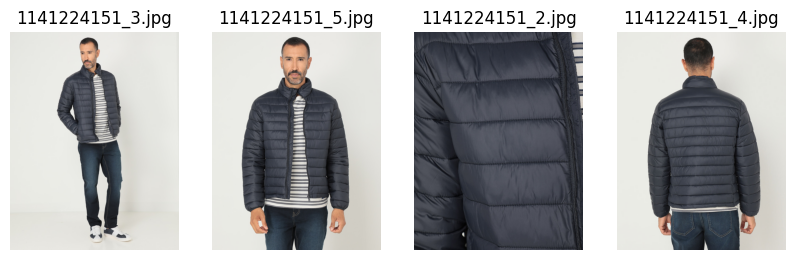

In [29]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def find_images_with_id(folder, image_id):
    """Returns a list of all image files in the folder that start with the given ID."""
    matching_images = [
        filename for filename in os.listdir(folder)
        if filename.startswith(f"{image_id}_")
    ]
    return matching_images

def show_images(folder, images):
    """Display the list of images using Matplotlib."""
    plt.figure(figsize=(10, 10))  # Adjust the size as needed
    for i, image_name in enumerate(images):
        img_path = os.path.join(folder, image_name)
        img = Image.open(img_path)  # Open the image

        # Plot the image
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.axis('off')  # Hide the axis
        plt.title(image_name)  # Optional: Show filename as title

    plt.show()

# Example usage
folder = "imagenes_descargadas"  # Replace with your folder path
image_name, distance = sorted_similarities[0]
psku = image_name.split("_")[0]

image_id = f"{psku}"  # Replace with the ID you're searching for

matching_images = find_images_with_id(folder, image_id)
print(f"Found {len(matching_images)} images with ID '{image_id}':")

# Display the images
if matching_images:
    show_images(folder, matching_images)
else:
    print(f"No images found with ID '{image_id}'.")
